In [1]:
import numpy as np
import math
import torch
from torch import nn
from torch import functional as F
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from Inference.Variational import MeanFieldVariationalDistribution
from Inference.VariationalBoosting import MeanFieldVariationalMixtureDistribution
from Tools.NNtools import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
# load data and make it in proper shape
data = torch.load('data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [4]:
model = nn.Sequential( nn.Linear(1, 20),
                       nn.Tanh(), 
                       nn.Linear(20, 1),
                     ).to(device)

In [5]:
param_count = get_param(model).shape[0]

In [6]:
flip_parameters_to_tensors(model)

In [7]:
prior = MeanFieldVariationalDistribution(param_count, sigma=1.0, device=device)
prior.mu.requires_grad = False
prior.rho.requires_grad = False

In [8]:
def logprior(x):
    return prior.log_prob(x)

In [9]:
def loglikelihood(theta, model, x, y, sigma_noise):
    def _log_norm(x, mu, std):
        return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)
    #set_param(model, theta)
    set_all_parameters(model, theta)
    y_pred = model(x)
    L = _log_norm(y_pred, y, torch.tensor([sigma_noise],device=device))
    return torch.sum(L).unsqueeze(-1)

In [10]:
def logposterior(theta, model, x, y, sigma_noise):
    return logprior(theta) + loglikelihood(theta, model, x, y, sigma_noise)

In [15]:
def show_variational_posterior_predictive(q):
    x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
    # Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    plt.xlim(-2, 2) 
    plt.ylim(-4, 4) 
    plt.scatter(x_data.cpu(), y_data.cpu())
    for _ in range(1000):
        z = q.sample()
        set_all_parameters(model, z)
        y_test = model(x_test)

        plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [11]:
def MAP():
    theta = torch.nn.Parameter( prior.sample(), requires_grad=True)

    optimizer = torch.optim.Adam([theta], lr=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.8)

    for t in range(10000):
        optimizer.zero_grad()

        L = -torch.mean(logposterior(theta, model, x_data, y_data, sigma_noise=0.1))
        L.backward()

        learning_rate = optimizer.param_groups[0]['lr']

        scheduler.step(L.detach().clone().cpu().numpy())
        optimizer.step()

        if learning_rate < 0.001:
            break
    return theta.detach().clone()

In [75]:
eMAP = []
for k in range(100):
    print(k)
    theta = MAP()
    eMAP.append(theta)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [95]:
components = []

In [96]:
for k in range(len(eMAP)):
    q_new = MeanFieldVariationalDistribution(param_count, sigma=0.1, device=device)
    q_new.mu = nn.Parameter(eMAP[k].squeeze(0).to(device), requires_grad=True) 
    components.append(q_new)

In [97]:
with torch.no_grad():
    proportions = torch.ones([len(eMAP)], requires_grad=True, device=device)/len(eMAP)

In [98]:
q = MeanFieldVariationalMixtureDistribution(proportions, components, device=device)

In [99]:
[c.rho.requires_grad_(True) for c in q.components]

[Parameter containing:
 tensor([-2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522,
         -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522,
         -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522,
         -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522,
         -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522,
         -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522,
         -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522,
         -2.2522, -2.2522, -2.2522, -2.2522, -2.2522], device='cuda:0',
        requires_grad=True), Parameter containing:
 tensor([-2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522,
         -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522,
         -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522, -2.2522,
         -2.2522, -2.2522, -2.2522, -2.2522,

In [100]:
#q.proportions.requires_grad_(True)

# Variational Distribution #

In [106]:
n_samples_ELBO = 100

In [107]:
optimizer = torch.optim.Adam( [c.rho for c in q.components]+[q.proportions], lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=200, factor=0.5)

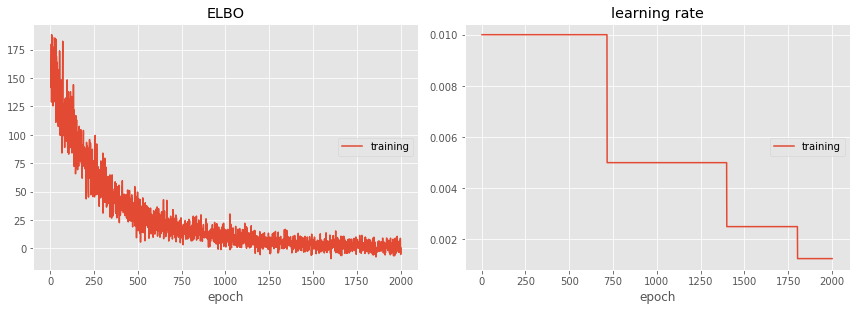

ELBO:
training   (min:   -8.962, max:  188.105, cur:    0.311)

learning rate:
training   (min:    0.001, max:    0.010, cur:    0.001)


In [253]:
%matplotlib inline
liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    optimizer.zero_grad()

    Ln = []
    Z = q.sample(n_samples_ELBO)
    MU = torch.stack([c.mu for c in q.components])
    SIGMA = torch.stack([c.sigma for c in q.components])
    A_ = -0.5*torch.log(2*np.pi*SIGMA**2)
    B_ = (SIGMA**2)
    for j in range(n_samples_ELBO):
        z = Z[j,:].unsqueeze(0)
        #LQ = q.log_prob(z)

        P = A_ - ( 0.5*(MU-z)**2)/B_ 
        LQ = torch.logsumexp(torch.log(q.proportions) + P.sum(dim=1), dim=0)
        
        LP = logposterior(z, model, x_data, y_data, sigma_noise=0.1)
        Ln.append(LQ - LP)

    L = torch.stack(Ln).mean()
    L.backward()
    
    learning_rate = optimizer.param_groups[0]['lr']
    
    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)
    
    if t % 10 == 0:
        liveloss.draw()

    optimizer.step()
    
    with torch.no_grad():
        torch.abs_(q.proportions)
        q.proportions = q.proportions / q.proportions.sum()

    if learning_rate < 0.001:
        break

In [200]:
def _log_norm(x, mu, std):
        return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [255]:
q.proportions

tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100], device='cuda:0')

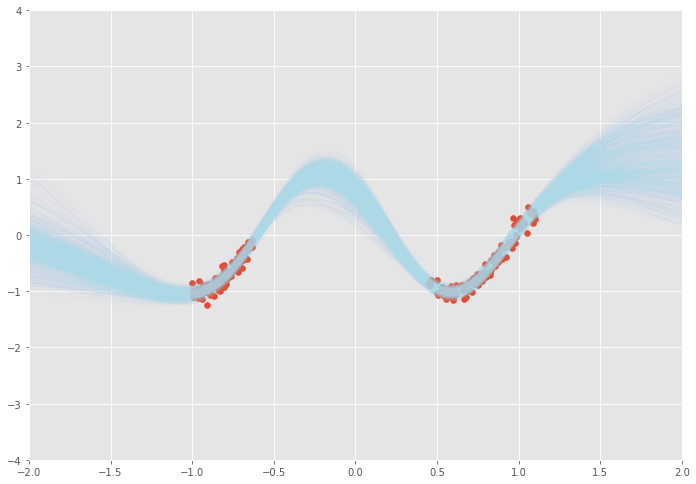

In [254]:
show_variational_posterior_predictive(q)

In [203]:
import time

start = time.time()
optimizer.zero_grad()

for i in range(10):
    #q.components[0].log_prob(z)
    #_log_norm(z, q.components[0].mu, q.components[0].sigma).sum()
    z = Z[j,:].unsqueeze(0)
    LQ = q.log_prob(z)

end = time.time()
print(end - start)

1.5609452724456787


In [243]:
MU = torch.stack([c.mu for c in q.components])
SIGMA = torch.stack([c.sigma for c in q.components])
P = -0.5*torch.log(2*np.pi*SIGMA**2) - ( 0.5*(MU-z)**2)/(SIGMA**2) 
torch.logsumexp(torch.log(q.proportions) + P.sum(dim=1), dim=0)